In [1]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas
import seaborn as sns

%matplotlib inline

In [4]:
paths_dict = {
    ("SARS", "MAE"): "../predictions/sars_stats_best_mae.csv",
    ("SARS", "Loss"): "../predictions/sars_stats_best_loss.csv",
    ("MERS", "MAE"): "../predictions/mers_stats_best_mae.csv",
    ("MERS", "Loss"): "../predictions/mers_stats_best_loss.csv",
}

full_stats_df = []
for (target, epoch_choice), stats_fn in paths_dict.items():
    df = pandas.read_csv(stats_fn, index_col=0)
    df["Train Target"] = target
    df["Epoch Choice Method"] = epoch_choice
    df["Pretrained"] = "False"
    full_stats_df.append(df)

pretrained_paths_dict = {
    ("SARS", "MAE"): "../predictions/sars_pretrained_stats_best_mae.csv",
    ("SARS", "Loss"): "../predictions/sars_pretrained_stats_best_loss.csv",
    ("MERS", "MAE"): "../predictions/mers_pretrained_stats_best_mae.csv",
    ("MERS", "Loss"): "../predictions/mers_pretrained_stats_best_loss.csv",
}
for (target, epoch_choice), stats_fn in pretrained_paths_dict.items():
    df = pandas.read_csv(stats_fn, index_col=0)
    df["Train Target"] = target
    df["Epoch Choice Method"] = epoch_choice
    df["Pretrained"] = "True"
    full_stats_df.append(df)

full_stats_df = pandas.concat(full_stats_df, axis=0, ignore_index=True)

full_stats_df["stat_type"] = [
    "err" if stat in {"MAE", "RMSE"} else "corr" for stat in full_stats_df["Statistic"]
]

# bar_width = 0.8
# all_stats = ["MAE", "RMSE", r"Spearman's $\rho$", r"Kendall's $\tau$"]
# adj_offset = bar_width / len(all_stats) / 2
# stat_adj_dict = dict(zip(all_stats, [-3, -1, 1, 3]))
# epoch_choice_pos_dict = {"MAE": 0, "Loss": 1}
# full_stats_df["x"] = [
#     epoch_choice_pos_dict[epoch_choice] + stat_adj_dict[stat] * adj_offset
#     for _, (epoch_choice, stat) in full_stats_df[["Epoch Choice Method", "Statistic"]].iterrows()
# ]

jitter_adj = 0.05
all_stats = ["MAE", "RMSE", r"Spearman's $\rho$", r"Kendall's $\tau$"]
stats_jitter_dict = dict(zip(all_stats, [-1, 1, -1, 1]))
adj_offset = 0.2
pretrain_adj_dict = dict(zip(["False", "True"], [-1, 1]))
epoch_choice_pos_dict = {"MAE": 0, "Loss": 1}
full_stats_df["x"] = [
    epoch_choice_pos_dict[epoch_choice]
    + pretrain_adj_dict[pretrain] * adj_offset
    + stats_jitter_dict[stat] * jitter_adj
    for _, (epoch_choice, pretrain, stat) in full_stats_df[
        ["Epoch Choice Method", "Pretrained", "Statistic"]
    ].iterrows()
]

full_stats_df

,Num Compounds,Statistic,Value,95ci_low,95ci_high,Train Target,Epoch Choice Method,Pretrained,stat_type,x
0,108,MAE,0.454969,0.371195,0.530869,SARS,MAE,False,err,-0.25
1,108,RMSE,0.622451,0.521388,0.727116,SARS,MAE,False,err,-0.15
2,108,Spearman's $\rho$,0.746349,0.657947,0.864378,SARS,MAE,False,corr,-0.25
3,108,Kendall's $\tau$,0.569198,0.476354,0.671768,SARS,MAE,False,corr,-0.15
4,108,MAE,0.454969,0.371157,0.531372,SARS,Loss,False,err,0.75
5,108,RMSE,0.622451,0.521727,0.726494,SARS,Loss,False,err,0.85
6,108,Spearman's $\rho$,0.746349,0.659232,0.865271,SARS,Loss,False,corr,0.75
7,108,Kendall's $\tau$,0.569198,0.477060,0.672040,SARS,Loss,False,corr,0.85
8,84,MAE,0.325124,0.268267,0.380646,MERS,MAE,False,err,-0.25
9,84,RMSE,0.418188,0.362459,0.478260,MERS,MAE,False,err,-0.15


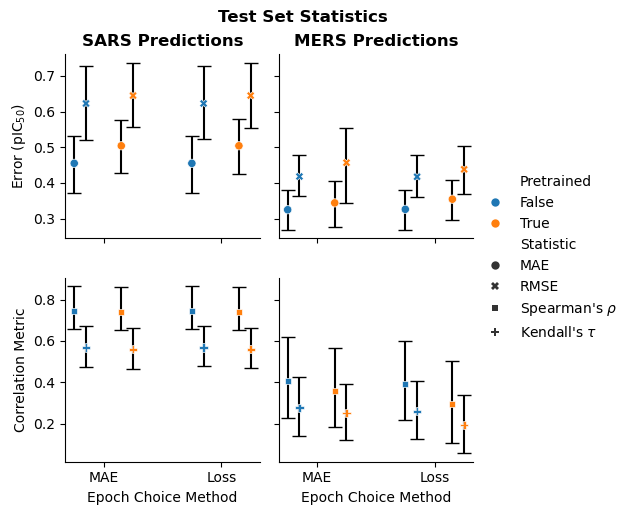

In [9]:
fg = sns.relplot(
    full_stats_df,
    x="x",
    y="Value",
    row="stat_type",
    row_order=["err", "corr"],
    hue="Pretrained",
    hue_order=["False", "True"],
    col="Train Target",
    col_order=["SARS", "MERS"],
    style="Statistic",
    style_order=["MAE", "RMSE", r"Spearman's $\rho$", r"Kendall's $\tau$"],
    facet_kws={"sharex": True, "sharey": "row"},
    height=2.5,
    kind="scatter",
)

fg.set_axis_labels("Epoch Choice Method", "")
fg.set_titles(template="")

# Set column titles
fg.axes.flatten()[0].set_title("SARS Predictions", fontdict={"fontweight": "bold"})
fg.axes.flatten()[1].set_title("MERS Predictions", fontdict={"fontweight": "bold"})

fg.axes[0, 0].set_ylabel("Error (pIC$_\mathrm{50}$)")
fg.axes[1, 0].set_ylabel("Correlation Metric")

# max_err = max([ax.get_ylim()[1] for ax in fg.axes[0, :].ravel()])
# # max_err = comb_stats_mean_df.loc[
# #     comb_stats_mean_df["split"] == "test", "95ci_high"
# # ].max()
# for ax in fg.axes[0, :].ravel():
#     ax.set_ylim(0, max_err)

# min_corr = min([0] + [ax.get_ylim()[0] for ax in fg.axes[1, :].ravel()])
# for ax in fg.axes[1, :].ravel():
#     ax.set_ylim(min_corr, 1)

fg.set(xticks=[0, 1], xticklabels=["MAE", "Loss"])

# Add in errorbars
for (stat_type, target), ax in fg.axes_dict.items():
    base_idx = (
        (full_stats_df["stat_type"] == stat_type)
        & (full_stats_df["Train Target"] == target)
    )
    for epoch_choice, stat in product(["MAE", "Loss"], all_stats):
        idx = (
            base_idx
            & (full_stats_df["Statistic"] == stat)
            & (full_stats_df["Epoch Choice Method"] == epoch_choice)
        )
        g = full_stats_df.loc[idx, :]
        # display(g)
        ax.errorbar(
            x=g["x"].values,
            y=g["Value"].values,
            yerr=np.abs(
                g[["95ci_low", "95ci_high"]].values.transpose()
                - g["Value"].values.transpose()
            ),
            fmt="none",
            ecolor="black",
            capsize=5,
            zorder=-10,
        )

fg.figure.suptitle("Test Set Statistics", y=1.02, fontweight="bold")
fg.savefig("../figures/test_set_stats.png", bbox_inches="tight", dpi=200)

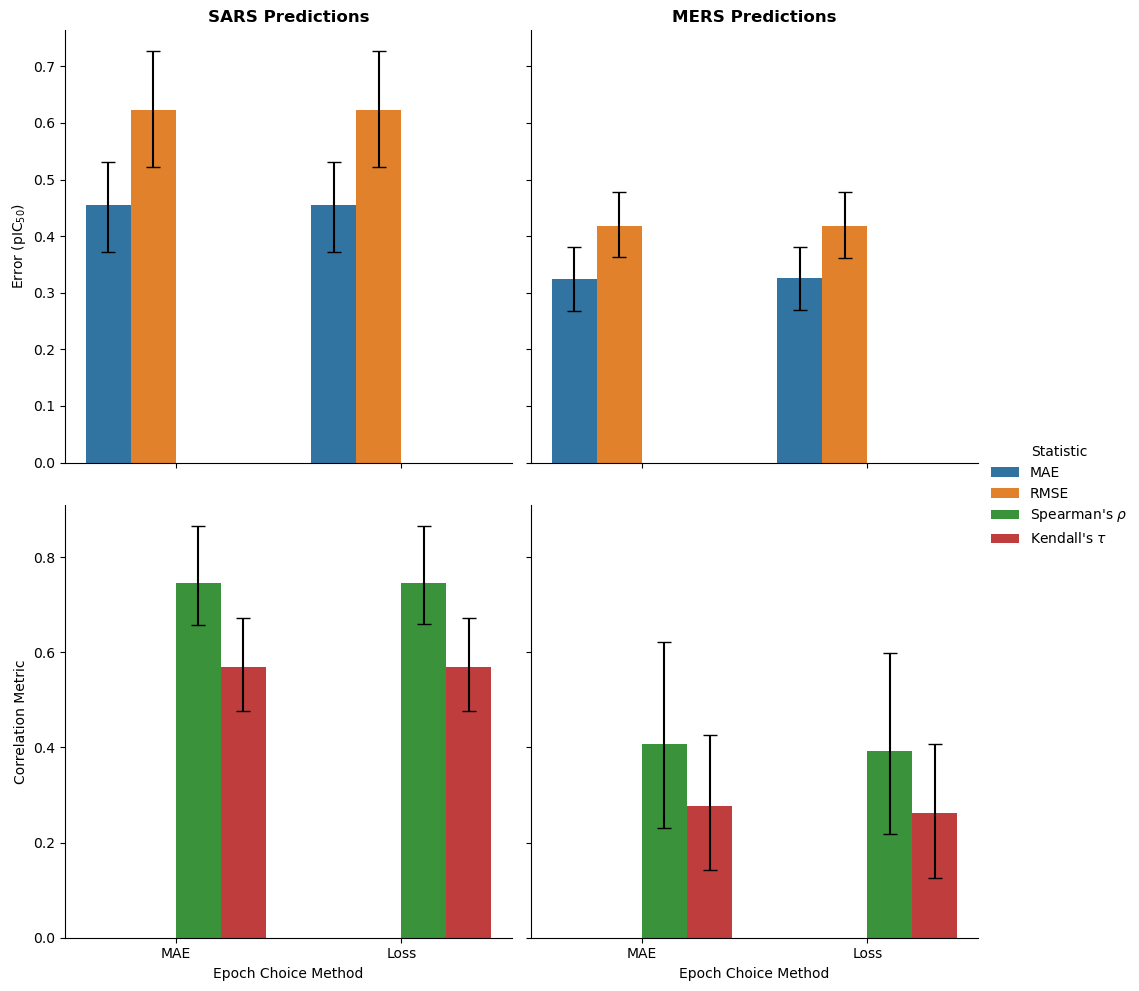

In [27]:
fg = sns.catplot(
    full_stats_df,
    x="Epoch Choice Method",
    order=["MAE", "Loss"],
    y="Value",
    hue="Statistic",
    hue_order=all_stats,
    col="Train Target",
    col_order=["SARS", "MERS"],
    row="stat_type",
    row_order=["err", "corr"],
    kind="bar",
    sharey="row",
)

fg.set_axis_labels("Epoch Choice Method", "")
fg.set_titles(template="")

# Set column titles
fg.axes.flatten()[0].set_title("SARS Predictions", fontdict={"fontweight": "bold"})
fg.axes.flatten()[1].set_title("MERS Predictions", fontdict={"fontweight": "bold"})

fg.axes[0, 0].set_ylabel("Error (pIC$_\mathrm{50}$)")
fg.axes[1, 0].set_ylabel("Correlation Metric")

# Add in errorbars
color_palette = dict(zip(all_stats, sns.color_palette()))
for (stat_type, target), ax in fg.axes_dict.items():
    base_idx = (
        (full_stats_df["stat_type"] == stat_type)
        & (full_stats_df["Train Target"] == target)
    )
    for epoch_choice, stat in product(["MAE", "Loss"], all_stats):
        idx = (
            base_idx
            & (full_stats_df["Statistic"] == stat)
            & (full_stats_df["Epoch Choice Method"] == epoch_choice)
        )
        g = full_stats_df.loc[idx, :]
        # display(g)
        ax.errorbar(
            x=g["x"].values,
            y=g["Value"].values,
            yerr=np.abs(
                g[["95ci_low", "95ci_high"]].values.transpose()
                - g["Value"].values.transpose()
            ),
            fmt="none",
            ecolor="black",
            # ecolor=color_palette[loss],
            capsize=5,
            # alpha=0.5,
        )
    # fg.refline(x=x, ls="--", c="black")

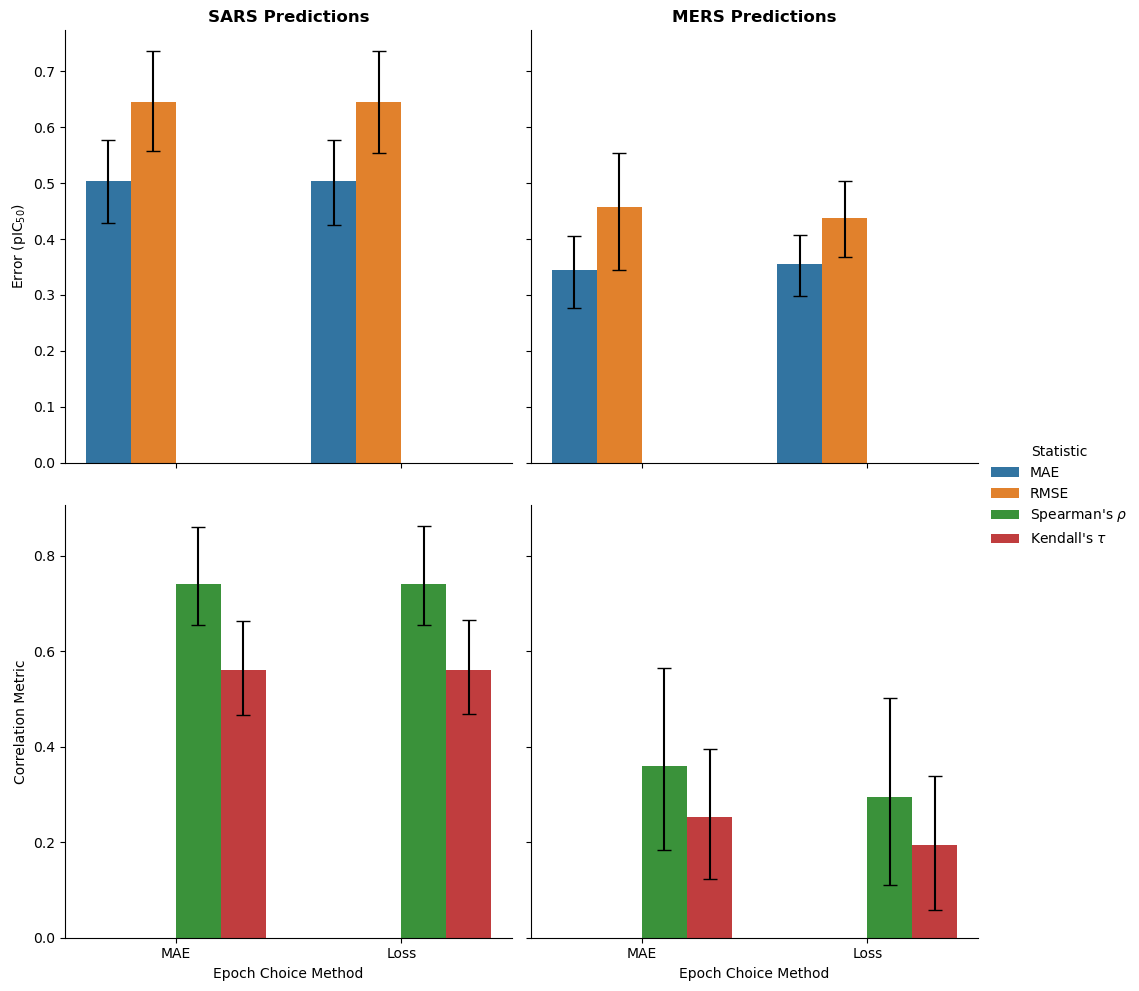

In [29]:
fg = sns.catplot(
    pretrained_full_stats_df,
    x="Epoch Choice Method",
    order=["MAE", "Loss"],
    y="Value",
    hue="Statistic",
    hue_order=all_stats,
    col="Train Target",
    col_order=["SARS", "MERS"],
    row="stat_type",
    row_order=["err", "corr"],
    kind="bar",
    sharey="row",
)

fg.set_axis_labels("Epoch Choice Method", "")
fg.set_titles(template="")

# Set column titles
fg.axes.flatten()[0].set_title("SARS Predictions", fontdict={"fontweight": "bold"})
fg.axes.flatten()[1].set_title("MERS Predictions", fontdict={"fontweight": "bold"})

fg.axes[0, 0].set_ylabel("Error (pIC$_\mathrm{50}$)")
fg.axes[1, 0].set_ylabel("Correlation Metric")

# Add in errorbars
color_palette = dict(zip(all_stats, sns.color_palette()))
for (stat_type, target), ax in fg.axes_dict.items():
    base_idx = (
        (pretrained_full_stats_df["stat_type"] == stat_type)
        & (pretrained_full_stats_df["Train Target"] == target)
    )
    for epoch_choice, stat in product(["MAE", "Loss"], all_stats):
        idx = (
            base_idx
            & (pretrained_full_stats_df["Statistic"] == stat)
            & (pretrained_full_stats_df["Epoch Choice Method"] == epoch_choice)
        )
        g = pretrained_full_stats_df.loc[idx, :]
        # display(g)
        ax.errorbar(
            x=g["x"].values,
            y=g["Value"].values,
            yerr=np.abs(
                g[["95ci_low", "95ci_high"]].values.transpose()
                - g["Value"].values.transpose()
            ),
            fmt="none",
            ecolor="black",
            # ecolor=color_palette[loss],
            capsize=5,
            # alpha=0.5,
        )
    # fg.refline(x=x, ls="--", c="black")